In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
    
import matplotlib.pyplot as plt # data visualization
import seaborn as sns # data visualization

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

# Перший погляд на дані

In [ ]:
train = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sales_train.csv')
train.head()

In [ ]:
train.info()

In [ ]:
train.describe()

In [ ]:
test = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/test.csv')
test.head()

In [ ]:
test.info()

In [ ]:
test.describe()

In [ ]:
item_categories = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/item_categories.csv')
item_categories.head()

In [ ]:
shops = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/shops.csv')
shops.head()

In [ ]:
items = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/items.csv')
items.head()

In [ ]:
sample_submission = pd.read_csv('/kaggle/input/competitive-data-science-predict-future-sales/sample_submission.csv')
sample_submission.head()

# Missing data

Перевіримо наявність пропущених значень у датасетах

In [ ]:
def missing(df):
    missing_df = pd.DataFrame({
        'missing_count': df.isnull().sum(),
        'missing_part': df.isnull().sum()/len(df)
    })
    missing_df = missing_df[missing_df['missing_count'] != 0]
    return missing_df

In [ ]:
missing(train)

In [ ]:
missing(test)

Пропущених значень в датасетах немає, що дуже добре.

# Outliers

Перевіримо дані на присутність аномальних значень

Для початку оберемо стовпчики, в яких можуть бути присутні аномалії.
Всі стовпчики з id таких даних мати не можуть, як і всі стовпчики з name, також стовпчик date має тип object. 
Залишились:
 - item_cnt_day - кількість проданих продуктів.
 - item_price - поточна ціна продукту
 - date_block_num - номер місяця поспіль (січень 2013 - 0, лютий 2013 - 1, ..., жовтень 2015 - 33)

In [ ]:
features_to_check = ['item_cnt_day', 'item_price', 'date_block_num']
for feature in features_to_check:
    plt.figure(figsize=(20, 3))
    sns.boxplot(data=train[feature], orient='h')
    plt.title(feature)
    plt.show()

Видалимо від'ємні значення із стовпчиків 'item_cnt_day', 'item_price'. Інші значення, які є досить високми не дуже доцілно видаляти, так як з одного боку, вони можуть зіпсувати модель, але з іншого, такі дані цілком можуть бути реальними і бути також присутніми в тестовому датасеті.

In [ ]:
train = train[train['item_cnt_day'] > 0]
train = train[train['item_price'] > 0]

# Dupcicates

Перевіримо дані на наявність дублікатів і у разі їх наявності видалимо їх.

In [ ]:
train.duplicated().sum()

In [ ]:
train = train.drop_duplicates()

# Огляд даних

Поглянемо на розподіл даних за часом. Для цього скористаємось стовпчиком із номером місяця і подивимось на продажі відносно місяців.

In [ ]:
df_to_plot = train.groupby(['date_block_num']).agg({'item_cnt_day': 'sum'})
plt.plot(df_to_plot['item_cnt_day'])

In [ ]:
df_to_plot.sort_values(by=['item_cnt_day'], ascending=False).head()

Отже, місяці 11 та 23 (тобто грудень) мають найвищі показники по продажу.

Також з графіка можна помітити тенденцію до зменшення кількості покупок (навіть в пікових моментах) і можна помітити, що данні мають сезонний характер.

Перевіримо тенденції відповідно до значень продажу не по кількості товарів, а по їх загальній ціні. Для цього спочатку додамо новий стовпчик із загальною ціною.

In [ ]:
train['item_cnt_day_sum'] = train.item_price * train.item_cnt_day

In [ ]:
df_to_plot = train.groupby(['date_block_num']).agg({'item_cnt_day_sum': 'sum'})
plt.plot(df_to_plot['item_cnt_day_sum'])

Отже, тендеція щодо зниження кількості прибутку відсутня, тобто товарів було продано менше, проте ціни на них були більші. Сезонність поведінки даних залишилась такою ж (свята (особливо Новий Рік), вихідні тощо).

Розглянемо найпопулярніші товари за весь час (найбільші по кількості продажів).

In [ ]:
top_categories = train.sort_values(by=['item_cnt_day'], ascending=False).head(10)
top_categories.plot.bar(x='item_id', y='item_cnt_day')

Виведемо найпопулярніші категорії

In [ ]:
top_categories_items = top_categories['item_id'].values
item_categories[item_categories['item_category_id'].isin(items[items['item_id'].isin(top_categories_items)]['item_category_id'].values)]

Розглянемо тепер магазини.

Для початку, розглянемо магазини відносно кількіості проданих товарів.

In [ ]:
shop_by_cnt = train.groupby('shop_id').agg({'item_cnt_day': 'sum'}).sort_values(by=['item_cnt_day'], ascending=False)
shop_by_cnt.plot.bar(figsize=(20, 10))

Далі розглянемо магазини відносно суми "прибутку".

In [ ]:
shop_by_cnt_sum = train.groupby('shop_id').agg({'item_cnt_day_sum': 'sum'}).sort_values(by=['item_cnt_day_sum'], ascending=False)
shop_by_cnt_sum.plot.bar(figsize=(20, 10))

Порівняємо, які саме магазини найбільш успішні по продажу в кількості і в сумі прибутку.

In [ ]:
shops[shops['shop_id'].isin(shop_by_cnt_sum.head(5).index)]

In [ ]:
shops[shops['shop_id'].isin(shop_by_cnt.head(5).index)]

Найкращими виявились однакві магазини при обох розглядах. До того ж можна помітити, що ці магазини знаходяться у найбільших містах.

Зробимо висновки щодо розглянутих даних:
- У даних є продажів - у грудні. Це час, коли люди роблять найбільше покупок на новорічні подарунки.
- Більшість товарів продавались з Москви та інших великих місти, таких як Санкт-Петербург, Хімки.
- У даних є чітка сезонність.
- Хоч можлива тенденція зменшення кількості проданих товарів з часом, проте ця тенденція непомітна, якщо розглядати прибуток в загальному (в сумі за кожен товар).
- Попередня тенденція також говорить про збільшення (що можна помітити по ціні однакових товарів впродовж всьоо часу).

# Нова підготовка до тренування моделі

# **---------------------------------------------------------**

# **---------------------------------------------------------**

In [ ]:
train

In [ ]:
train.drop(columns=['item_cnt_day_sum'], inplace=True)

In [ ]:
train['month_num'] = train['date'].str.split('.').str.get(1)
train.drop(columns=['date'], inplace=True)
train['month_num'] = train['month_num'].apply(pd.to_numeric)
train['month_num'] = train['month_num'].astype('int16')
train.head(5)

Згрупуємо данні за 'date_block_num', 'shop_id', 'item_id', так як необхідно отримати передбачення на місяць, а також для кожного магазину та кожного товару.

In [ ]:
train_grpd = train.drop(columns=['month_num'])\
        .groupby(['date_block_num', 'shop_id', 'item_id'])\
        .agg({'item_price': 'mean', 'item_cnt_day': 'sum'})

train_grpd.head(5)

Об'єднаємо всі присутні таблиці, щоб отримати нові фічі або нову інформацію.

In [ ]:
train_grpd = train_grpd.join(shops.set_index('shop_id'), how='inner')
train_grpd

In [ ]:
train_grpd = train_grpd.join(items.set_index('item_id'), how='inner')
train_grpd

In [ ]:
train_grpd = train_grpd.join(item_categories.set_index('item_category_id'), on='item_category_id', how='inner')
train_grpd

На основі назви магазину можна отритмати його місцезнаходження.

In [ ]:
train_grpd['location'] = train_grpd['shop_name'].str.split().str.get(0)
train_grpd.head(5)

Тепер стовпчики з назвами можна видалити.

In [ ]:
train_grpd.drop(columns=['item_category_name', 'item_name', 'shop_name'], inplace=True)
train_grpd.head(5)

Додама стовпчик з реальним номером місяця.

In [ ]:
months_numbers = train[['date_block_num', 'month_num']].drop_duplicates()
train_grpd = train_grpd.join(months_numbers.set_index('date_block_num'), how='inner')
train_grpd

Так як дані були об'єднанні та агреговані - змінимо назву стовпичків, значення яких були змінені.

In [ ]:
train_grpd.rename(columns={'item_cnt_day': 'item_cnt_month', 'item_price': 'item_price_mean'}, inplace=True)
train_grpd

In [ ]:
train_grpd.reset_index()['item_cnt_month'].plot(figsize=(10, 5))

# Тестовий сет

In [ ]:
test.head()

In [ ]:
len(test)

Спочатку необхідно додати номер місяця - 11 та 34.

In [ ]:
test['date_block_num'] = 34
test['month_num'] = 11
test.head()

Тепер проведемо ті ж маніпуляції, що і з тренувальним сетом.

In [ ]:
test_df = test.join(shops.set_index('shop_id'), on='shop_id', how='inner')
test_df.head()

In [ ]:
test_df = test_df.join(items.set_index('item_id'), on='item_id', how='inner')
test_df.head()

In [ ]:
test_df = test_df.join(item_categories.set_index('item_category_id'), on='item_category_id', how='inner')
test_df.head()

In [ ]:
test_df['location'] = test_df['shop_name'].str.split().str.get(0)
test_df.head(5)

In [ ]:
test_df.drop(columns=['item_category_name', 'item_name', 'shop_name'], inplace=True)
test_df.head(5)

In [ ]:
train_grpd.sample(10)

Додамо також колонку із середньою ціною.

In [ ]:
test_df

In [ ]:
test_df.join(train_grpd.reset_index(level=0)['item_price_mean'], on=['shop_id', 'item_id'], how='inner')

# Регресія

In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.compose import TransformedTargetRegressor
from sklearn.linear_model import RidgeCV

Виділимо лейбли, а також видалимо непотрібні стовпчики в наших сетах.

In [ ]:
train_Y = train_grpd['item_cnt_month'].values
train_X = train_grpd\
        .reset_index()\
        .drop(columns=['item_cnt_month', 'item_price_mean'])
train_X['location'] = train_X['location'].astype('category')
test_X = test_df.drop(columns=['ID'])
print(train_X.columns)
print(test_X.columns)

Закодуємо категоріальну змінну ('location').

In [ ]:
train_X = pd.get_dummies(train_X)
test_X = pd.get_dummies(test_df)

print(train_X.shape)
print(test_X.shape)

Тепер необхідно виправити те, що різна кількість стовпчиків (що було спричинене кодуванням змінної).

In [ ]:
train_X, test_X = train_X.align(test_X, join='inner', axis=1)

print(train_X.shape)
print(test_X.shape)

In [ ]:
x_train, x_test, y_train, y_test = train_test_split(train_X, train_Y)

In [ ]:
regr = LinearRegression()
regr.fit(x_train, y_train)

In [ ]:
test_Y = regr.predict(test_X)
test_Y

In [ ]:
print('Train set mse:', mean_squared_error(y_train, regr.predict(x_train)))
print('Test set mse:', mean_squared_error(y_test, regr.predict(x_test)))
print('Test set score:', regr.score(x_train, y_train))

In [ ]:
submission_linear_regression = pd.DataFrame({
    "ID": test_X.reset_index().drop(columns=['index']).index, 
    "item_cnt_month": test_Y
})
submission_linear_regression.to_csv('submission_linear_regression.csv', index=False)

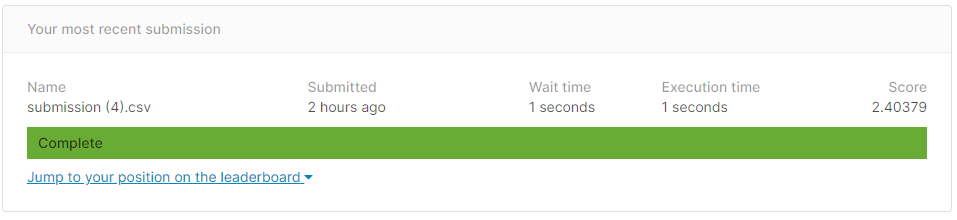

Тепер спробуємо скористотися логарифмуванням для збільшення точності моделі.

In [ ]:
regr_trans = TransformedTargetRegressor(regressor=LinearRegression(),
                                        func=np.log1p,
                                        inverse_func=np.expm1)

regr_trans.fit(x_train, y_train)

In [ ]:
test_Y_log = regr_trans.predict(test_X)
test_Y_log

In [ ]:
print('Train set mse:', mean_squared_error(y_train, regr_trans.predict(x_train), ))
print('Test set mse:', mean_squared_error(y_test, regr_trans.predict(x_test)))
print('Test set score:', regr_trans.score(x_train, y_train))

In [ ]:
submission_transformed_target_regressor = pd.DataFrame({
    "ID": test_X.reset_index().drop(columns=['index']).index, 
    "item_cnt_month": test_Y_log
})
submission_transformed_target_regressor.to_csv('submission_transformed_target_regressor.csv', index=False)

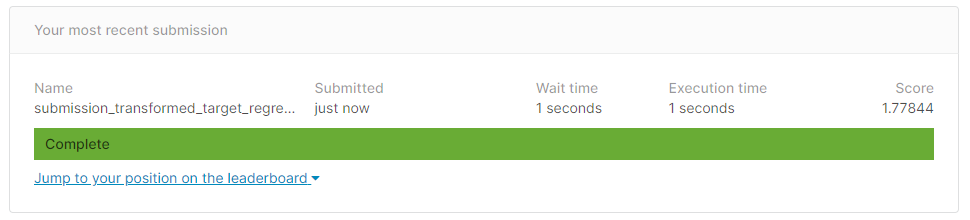

In [ ]:
regr_trans_CV = TransformedTargetRegressor(regressor=RidgeCV(),
                                        func=np.log1p,
                                        inverse_func=np.expm1)

regr_trans_CV.fit(x_train, y_train)

In [ ]:
test_Y_log_CV = regr_trans_CV.predict(test_X)
test_Y_log_CV

In [ ]:
print('Train set mse:', mean_squared_error(y_train, regr_trans_CV.predict(x_train), ))
print('Test set mse:', mean_squared_error(y_test, regr_trans_CV.predict(x_test)))
print('Test set score:', regr_trans_CV.score(x_train, y_train))

In [ ]:
submission_transformed_target_regressor_CV = pd.DataFrame({
    "ID": test_X.reset_index().drop(columns=['index']).index, 
    "item_cnt_month": test_Y_log_CV
})
submission_transformed_target_regressor.to_csv('submission_transformed_target_regressor_CV.csv', index=False)

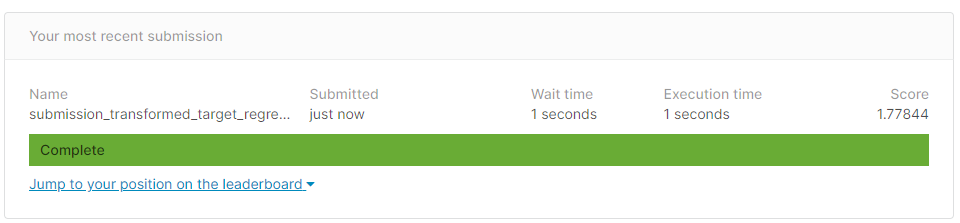